# Computational Social Science Project #2 

**Enter your Name:**Cindy Alvarez

*Semester:* Fall 2024


Below we fill in some of the code you might use to answer some of the questions. Here are some additional resources for when you get stuck:
* Code and documentation provided in the course notebooks  
* [Markdown cheatsheet](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) to help with formatting the Jupyter notebook
* Try Googling any errors you get and consult Stack Overflow, etc. Someone has probably had your question before!
* Send me a pull request on GitHub flagging the syntax that's tripping you up 

**INSTRUCTIONS:** For this project, copy all of the files in the Project 2 folder in the course repo into a "Project 2" subfolder within the "Computational Social Science Projects" directory that you created for the first project. You will work on the project locally, push your project to GitHub, and submit a link to the GitHub repo on bCourses by the project deadline. Be sure the final submission is in the main branch, which is what I'll pull down and re-run to grade. 

## 1. Introduction/Setup

#### a) Import relevant libraries
Here are some libraries you will need to get started. Along the way you may need to add more. Best practice is to add them here at the top of the script.

In [1]:
#
# import libraries you might need here 
#-----------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score

# use magic function
%matplotlib inline


# set style
sns.set_style("darkgrid")

# use random seed for consistent results 
np.random.seed(273)

#### b) Read in and inspect data frame 
Read in the data frame and look at some of its attributes. Read in the data contained in the projoect folder: "Diabetes with Population Info by County 2017.csv".

In [2]:
#
# read in and inspect data frame
#-----------
# Note that "CountyFips" needs to be a string so the leading 0 isn't dropped (only if you want to make choropleth map) 
diabetes = pd.read_csv("Diabetes with Population Info by County 2017.csv", 
                       dtype={"CountyFIPS": str}) 

In [3]:
#
# look at shape
#-----------
# look at the dimensions of the diabetes data frame
print('shape: ', diabetes.shape) 

shape:  (3220, 95)


In [4]:
#
# set pandas parameters
#-----------
# tells pandas how many rows to display when printing so results don't get truncated
pd.set_option('display.max_rows', 100)

# look at the data types for each column in diabetes df (likely be located under each row bc column names are long)
print('data types:', diabetes.dtypes)

data types: County                                                                                                                                                   object
State                                                                                                                                                    object
CountyFIPS                                                                                                                                               object
Diabetes_Number                                                                                                                                          object
Obesity_Number                                                                                                                                           object
Physical_Inactivity_Number                                                                                                                               object
sex and age_total population

Immediately, we see that some of the features that should be numeric (e.g., Diabetes_Number, Obesity_Number,  and Physical_Inactivity_Number) are not. We can check to see what the non-numeric values are in a column where we are expecting numeric information with a combination of `str.isnumeric()` and `unique()`.

In [5]:
#
# identify non-numeric features
#-----------
# Return rows where the column "Diabetes_Number" is non-numeric and get the unique values of these rows
# the "~" below in front of diabetes negates the str.isnumeric() so it only takes non-numeric values
print(diabetes[~diabetes['Diabetes_Number'].str.isnumeric()]['Diabetes_Number'].unique()) 

['Suppressed']


In [6]:
#
# Now do the same as above, but for "Obesity_Number"
#-----------
print(diabetes[~diabetes['Obesity_Number'].str.isnumeric()]['Obesity_Number'].unique()) 


['No Data']


In [7]:
#
# Now do the same as above, but for "Physical_Inactivity_Number" 
#-----------
print(diabetes[~diabetes['Physical_Inactivity_Number'].str.isnumeric()]['Physical_Inactivity_Number'].unique()) 


['No Data']


These values ("Suppresssed" and "No Data") contained in the two respective columns are coercing these features to objects instead of them being  integers. Let's drop those rows in the next section, and also recode "Physical_Inactivity_Number" feature to be an integer.

#### c) Recode variables

Convert 'Diabetes_Number', 'Obesity_Number', and 'Physical_Inactivity_Number' to integers below so we can use them in our analysis. Also fill in the object type we want to recode 'sex and age_total population_65 years and over_sex ratio (males per 100 females)' too (you'll have to scroll all the way over to the right).

In [8]:
#
# Recode variables
#-----------

# Diabetes
# ----------
# keep only useful info about our target feature, i.e., where diabetes_number not = 'Suppressed'
# note that the inside reference to the diabetes df identifies the column, and the outer calls specific rows according to a condition 
diabetes = diabetes[diabetes['Diabetes_Number']!='Suppressed'] 

# use the astype method on Diabetes_Number to convert it to an integer...if you are not sure, what does the astype() documentation tell you are possible arguments? 
diabetes['Diabetes_Number'] = diabetes['Diabetes_Number'].astype('int64') 

# Obesity
# ----------
diabetes = diabetes[diabetes['Obesity_Number']!='No Data']

# converting obesity to an integer

diabetes['Obesity_Number'] = diabetes['Obesity_Number'].astype('int64')

# Physical Inactivity
# ----------

diabetes = diabetes[diabetes['Physical_Inactivity_Number']!='No data']

# converting inactivity to an integer

diabetes['Physical_Inactivity_Number'] = diabetes['Physical_Inactivity_Number'].astype('int64')

# Some final changes 
# ----------
# 65+ sex ratio had one "-" in it so let's drop that row first
diabetes = diabetes[diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)']!= "-"]

# change to numeric from string, since it originally included the "-", which made it a string
# you'll have to decide whether to make it integer or float 
diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'] = diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'].astype('float64')

We should probably scale our count variables to be proportional to county population. We create the list 'rc_cols' to select all the features we want to rescale, and then use the `.div()` method to avoid typing out every single column we want to recode. 

In [9]:
# Checking to see what the "sex and age_total population_median age (years)" variable contains:

print(diabetes['sex and age_total population_median age (years)'].head(5))

0    37.8
1    42.8
2    39.9
3    39.9
4    40.8
Name: sex and age_total population_median age (years), dtype: float64


In [10]:
#
# Scale to county populations
#-----------

# select count variables to recode to percentages; make sure we leave out ratios and our population variable 
# because these don't make sense to scale by population. Also, leave out "sex and age_total population_median age (years)" because this is the median
# age and does not make sense to scale by population
rc_cols = [col for col in diabetes.columns if col not in ['County', 'State', 'CountyFIPS', 
                                                        'sex and age_total population_65 years and over_sex ratio (males per 100 females)', 
                                                        'sex and age_total population_sex ratio (males per 100 females)', 
                                                        'sex and age_total population_18 years and over_sex ratio (males per 100 females)',  
                                                        'race_total population', 'sex and age_total population_median age (years)']]
           
# recode all selected columns to numeric
diabetes[rc_cols] = diabetes[rc_cols].apply(pd.to_numeric, errors='coerce') 

# divide all columns but those listed above by total population to calculate rates
diabetes[rc_cols] = diabetes[rc_cols].div(diabetes['race_total population'], axis=0)

Let's check our work. Are all rates bounded by 0 and 1 as expected? 

In [11]:
#
# check
#-----------
# set pandas options
pd.set_option('display.max_columns', None)

# inspect recoded values
diabetes_summary = diabetes.describe().transpose() # note we use the transpose method rather than .T because this object is not a numpy array
  
# check recoding 
with pd.option_context('display.max_rows', 100, 'display.max_columns', None): 
    display(diabetes_summary.iloc[ : ,[0,1,3,7]]) # select which columns in the summary table we want to present

,count,mean,min,max
Diabetes_Number,3112.0,0.092857,0.019038,2.242079e-01
Obesity_Number,3112.0,0.251666,0.088946,4.767883e-01
Physical_Inactivity_Number,3112.0,0.200861,0.064949,3.922853e-01
sex and age_total population_65 years and over_sex ratio (males per 100 females),3112.0,84.275643,34.700000,2.200000e+02
race_total population,3112.0,103682.624036,228.000000,1.009805e+07
race_total population_one race,3112.0,0.976059,0.713126,1.000000e+00
race_total population_two or more races,3112.0,0.023941,0.000000,2.868743e-01
race_total population_one race_1,3112.0,0.976059,0.713126,1.000000e+00
race_total population_one race_white,3112.0,0.831107,0.038912,1.000000e+00
race_total population_one race_black or african american,3112.0,0.090215,0.000000,8.741228e-01


#### d) Check for duplicate columns

There are a lot of columns in this data frame. Let's see if there are any are duplicates. Note that Pandas will not allow them to have the same exact column name, so they will likely be distinct on column name but will be copies otherwise.

In [12]:
#
# Check for duplicate columns
#-----------
# I used Google to figure this out, and adapted this example for our purposes:  
# source: https://thispointer.com/how-to-find-drop-duplicate-columns-in-a-dataframe-python-pandas/ 
def getDuplicateColumns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
    return list(duplicateColumnNames)

duplicateColumnNames = list(getDuplicateColumns(diabetes))
print('Duplicate Columns are as follows: ')
duplicateColumnNames

Duplicate Columns are as follows: 


['race_total population_one race_1',
 'sex and age_total population',
 'hispanic or latino and race_total population',
 'sex and age_total population_18 years and over_1',
 'sex and age_total population_65 years and over_1',
 'race_total population_two or more races_1']

In [13]:
#
# drop columns from duplicates list
#-----------
# now drop list of duplicate features from our df using the .drop() method
diabetes = diabetes.drop(columns= ['sex and age_total population',
 'race_total population_two or more races_1',
 'sex and age_total population_18 years and over_1',
 'hispanic or latino and race_total population',
 'race_total population_one race_1',
 'sex and age_total population_65 years and over_1']) 

Finally, there are many states accounted for the in dataset. If we convert this column to a categorical variable, and create dummies, it will create a rather sparse matrix (many 0s in our dataset) becuase there will be 49 dummy variables. One alternative is to classify each state to a larger US region and use that variable instead of state. The following code will do that.

In [14]:
# Define a dictionary mapping states to regions
state_to_region = {
    'Alabama': 'Southeast',
    'Alaska': 'West',
    'Arizona': 'West',
    'Arkansas': 'South',
    'California': 'West',
    'Colorado': 'West',
    'Connecticut': 'Northeast',
    'Delaware': 'Northeast',
    'District of Columbia': 'Southeast',
    'Florida': 'Southeast',
    'Georgia': 'Southeast',
    'Hawaii': 'West',
    'Idaho': 'West',
    'Illinois': 'Midwest',
    'Indiana': 'Midwest',
    'Iowa': 'Midwest',
    'Kansas': 'Midwest',
    'Kentucky': 'South',
    'Louisiana': 'South',
    'Maine': 'Northeast',
    'Maryland': 'Northeast',
    'Massachusetts': 'Northeast',
    'Michigan': 'Midwest',
    'Minnesota': 'Midwest',
    'Mississippi': 'South',
    'Missouri': 'Midwest',
    'Montana': 'West',
    'Nebraska': 'Midwest',
    'Nevada': 'West',
    'New Hampshire': 'Northeast',
    'New Jersey': 'Northeast',
    'New Mexico': 'West',
    'New York': 'Northeast',
    'North Carolina': 'Southeast',
    'North Dakota': 'Midwest',
    'Ohio': 'Midwest',
    'Oklahoma': 'South',
    'Oregon': 'West',
    'Pennsylvania': 'Northeast',
    'Rhode Island': 'Northeast',
    'South Carolina': 'Southeast',
    'South Dakota': 'Midwest',
    'Tennessee': 'South',
    'Texas': 'South',
    'Utah': 'West',
    'Vermont': 'Northeast',
    'Virginia': 'Southeast',
    'Washington': 'West',
    'West Virginia': 'South',
    'Wisconsin': 'Midwest',
    'Wyoming': 'West'
}

# Add a new 'Region' column based on the mapping
diabetes['Region'] = diabetes['State'].map(state_to_region)

# Print to verify'Region' column has been added
diabetes


,County,State,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some

## 2. Exploratory Data Analysis

Make at least two figures (feel free to make more) and explain their relevance to the scientific problem. The goal here is to uncover interesting patterns in the data, learn more about the scope of the problem, and communicate these findings to your audience in clear ways.

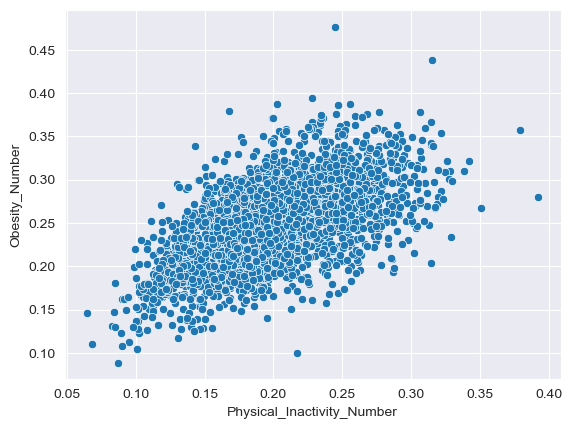

In [15]:
#
# EDA #1: Exploring the relationship between physical inactivity and obesity. This scatterplot demonstrates the positive and seemingly linear 
# relationship between rates of physical inactivity per county and obesity rates per county. While unsurprising, the stark positive relationship
# reinforces the idea that physical activity is strongly associated with obesity. It is also important to understand the relationship between obesity
# and diabetes. 
#-----------

sns.scatterplot(x = "Physical_Inactivity_Number",
                y = "Obesity_Number",
                data = diabetes);


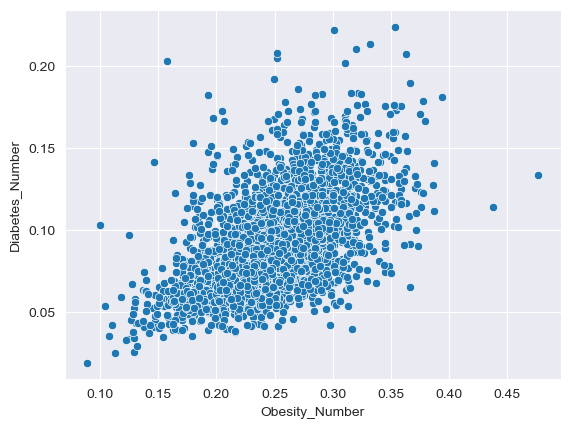

In [16]:
#
# EDA #2 Exploring the relationship bewtween obesity and diabetes rates. This scatterplot demonstrates the strong, positive relationship between 
# the rates of obesity and the rates of diabetes by county. This illustrates that obesity could be a strong predictor of diabetes in our model.  
#-----------

sns.scatterplot(x = "Obesity_Number",
                y = "Diabetes_Number",
                data = diabetes);


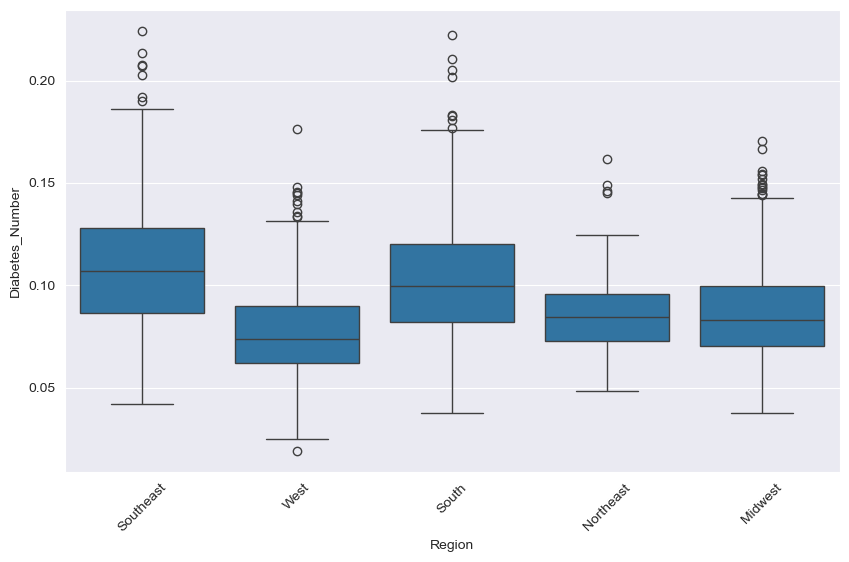

In [17]:
#
# EDA #3 These box plots demonstrate the relationship between the rate of diabetes and regions in the United States. Qualitatively, it seems that rates 
# of diabetes are higher in the Southeast and the South than they are in the West, Northeast, and Midwest. Region might be a good predictor of diabetes.
# Given our scatterplots above, we might expect to see higher rates of physical inactivity and obesity in the South and Southeast as well.
# ----------

plt.figure(figsize=(10, 6))

sns.boxplot(data=diabetes, 
            x="Region", 
            y="Diabetes_Number")
plt.xticks(rotation=45)
plt.show()


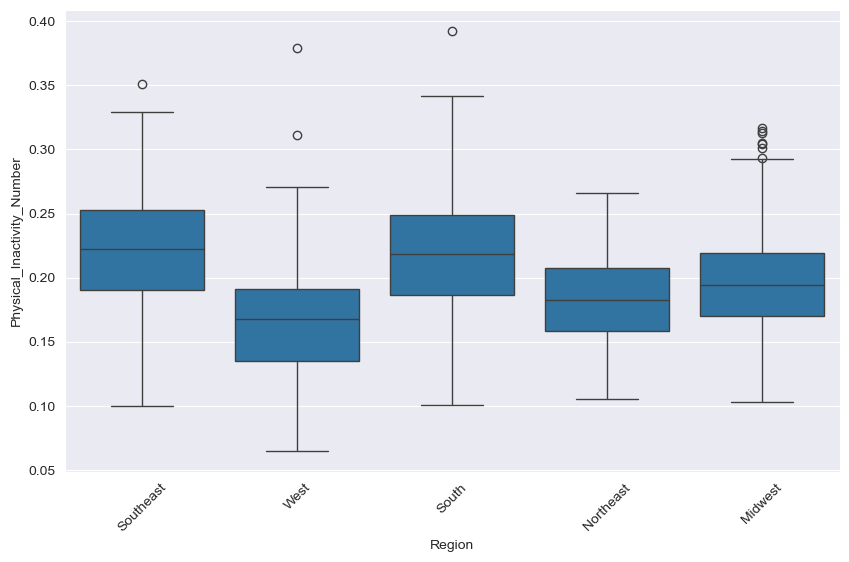

In [18]:
#
# EDA #4 These box plots demonstrate the relationship between the rate of of physical inactivity and regions in the United States. It seems that 
# rates of physical inactivity are also higher in the Southeast and the South than they are in the West, Northeast, and Midwest. This supports the 
# findings from our scatterplots above as physical inactivity was positively associated with obesity which was positively associated with diabetes. 
# It makes sense that regions with higher rates of diabetes also have higher rates of physical inactivity.
# ----------

plt.figure(figsize=(10, 6))

sns.boxplot(data=diabetes, 
            x="Region", 
            y="Physical_Inactivity_Number")
plt.xticks(rotation=45)
plt.show()

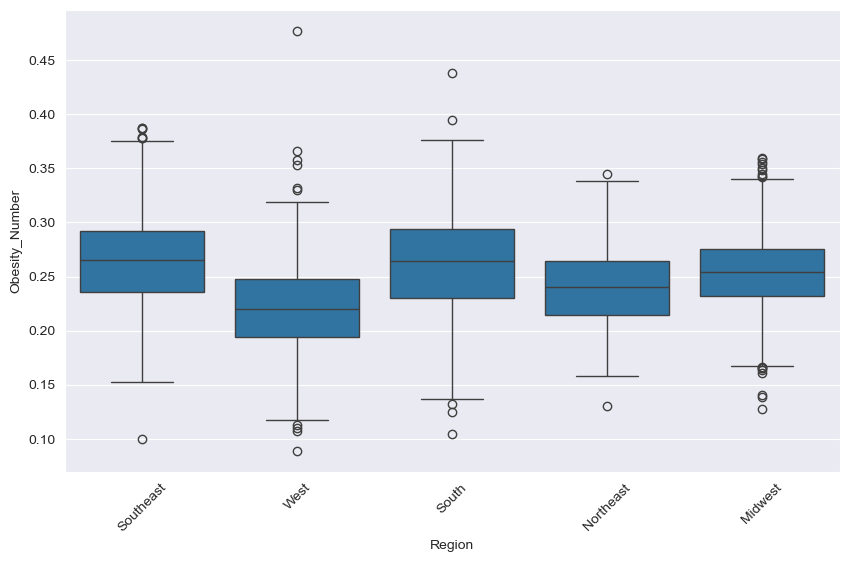

In [19]:
#
# EDA #5 Finally, these box plots demonstrate the relationship between rates of of obesity and regions in the United States. Unsurprisingly, these 
# boxplots Mirror the boxplots above, showing that rates of obesity are also higher in the Southeast and the South than they are in the West, Northeast, 
# and Midwest. 
# ----------

plt.figure(figsize=(10, 6))

sns.boxplot(data=diabetes, 
            x="Region", 
            y="Obesity_Number")
plt.xticks(rotation=45)
plt.show()

## 3. Prepare to Fit Models

### 3.1 Finalize Data Set

We've already cleaned up the data, but we can make a few more adjustments before partitioning the data and training models. Let's recode 'Region' to be a categorical variable using `pd.get_dummies` and drop 'State'. Also, we'll drop 'County' because 'CountyFIPS' is already a unique identifier for the county. 

In [20]:
#
# Drop and get dummies
#-----------

# create dummy features out of 'Region', which might be related to diabetes rates 
diabetes_clean = pd.get_dummies(data=diabetes, 
                               columns = ['Region'],  
                               drop_first = True) # drop the first as a reference 

# drop 'County' and 'State' variables
diabetes_clean = diabetes_clean.drop(labels = ['County', 'State'],
                               axis = 1) # 1 tells python we want to drop columns. 0 tells python we want to drop rows

# look at first 10 rows of new data frame 
diabetes_clean.head(10)

,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some other race -

### 3.2 Partition Data, Feature Selection, and Standardization

Now, we will partition our data to prepare it for the training process. Ultimately we want to use a 60% train—20% validation—20% test in this case. More data in the training set lowers bias, but then increases variance in the validation/test sets. Balancing between bias and variance with choice of these set sizes is important as we want to ensure that there is enough data to train on to get good predictions, but also want to make sure our hold-out sets are representative enough.

Work through partitioning the data into the test/train/validation sets in the chunks below. Be sure to that if you are using Ridge or LASSO, you Standardize the data. Where you do this in the workflow matters so be clear about where you are doing this and why. 

In [21]:
#
# Partition data
#-----------

# import library
from sklearn.model_selection import train_test_split

# create y dataframe 
y = diabetes_clean['Diabetes_Number']

# create X dataframe (include everything except "Diabetes_Number", our target, 
# and "race alone or in combination with one or more other races_total population")
X = diabetes_clean.drop(['Diabetes_Number', 'race alone or in combination with one or more other races_total population'],
                 axis = 1)

Investigate whether there are any features that you should remove prior to spliting and model fitting. You may also consider using plots and relationships you found in the EDA stage for this question. Be sure to justify your logic. 

In [22]:
#
# Initial feature selection:
#
# Below, I am removing the feature: "hispanic or latino and race_total population_not hispanic or latino" because it is the perfect inverse of another
# feature that is already included in the dataset: "hispanic or latino and race_total population_hispanic or latino (of any race)". As such, we do not 
# need to include both because they would be perfectly colinear. 
#-----------

X = X.drop('hispanic or latino and race_total population_not hispanic or latino',
          axis = 1)


In [23]:
# Checking for other highly correlated features that may not be as obvious as the above feature:
# ---

correlation_matrix = X.corr()
high_corr_pairs = np.where(np.abs(correlation_matrix) > 0.9)
high_corr_pairs = [(correlation_matrix.index[x], correlation_matrix.columns[y], correlation_matrix.iloc[x, y]) 
                   for x, y in zip(*high_corr_pairs) if x != y]

# Create markdown table header
print("| Feature 1 | Feature 2 | Correlation |")
print("|-----------|-----------|-------------|")

# Print pairs in table format, sorted by absolute correlation value
for feat1, feat2, corr in sorted(high_corr_pairs, key=lambda x: abs(x[2]), reverse=True):
    print(f"| {feat1} | {feat2} | {corr:.3f} |")

| Feature 1 | Feature 2 | Correlation |
|-----------|-----------|-------------|
| sex and age_total population_under 18 years | sex and age_total population_18 years and over | -1.000 |
| sex and age_total population_18 years and over | sex and age_total population_under 18 years | -1.000 |
| sex and age_total population_male | sex and age_total population_female | -1.000 |
| sex and age_total population_female | sex and age_total population_male | -1.000 |
| race_total population_one race | race_total population_two or more races | -1.000 |
| race_total population_two or more races | race_total population_one race | -1.000 |
| race_total population_one race_black or african american | hispanic or latino and race_total population_not hispanic or latino_black or african american alone | 1.000 |
| hispanic or latino and race_total population_not hispanic or latino_black or african american alone | race_total population_one race_black or african american | 1.000 |
| race_total population_

In [24]:
print(f"Original shape: {X.shape}")

Original shape: (3112, 88)


In [25]:
# The above output shows that there are several groups of highly correlated features that we should simplify: 1) Sex and age statistics, and 2) Race 
# statistics. As such we will remove redundant features:
# ----------

# For sex and age features
features_to_drop = [
    'sex and age_total population_female',  # Keep male, drop female (perfectly correlated)
    'sex and age_total population_16 years and over',  # Keep 18 years and over
    'sex and age_total population_18 years and over_sex ratio (males per 100 females)',  # Keep total sex ratio
    'sex and age_total population_62 years and over',  # Keep 65 and over
    'sex and age_total population_65 years and over_male',  # Keep total 65+
    'sex and age_total population_65 years and over_female'  # Keep total 65+
]

# For race features
features_to_drop.extend([
    'race_total population_two or more races',  # Keep one race, drop two or more (perfectly correlated)
    'race alone or in combination with one or more other races_total population_white',  # Keep one race versions
    'race alone or in combination with one or more other races_total population_black or african american',
    'race alone or in combination with one or more other races_total population_asian',
    'race alone or in combination with one or more other races_total population_american indian and alaska native',
    'race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander',
    'race alone or in combination with one or more other races_total population_some other race',
    'hispanic or latino and race_total population_not hispanic or latino_black or african american alone',  # Keep one race versions
    'hispanic or latino and race_total population_not hispanic or latino_asian alone',
    'hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone',
    'hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone'
])

# Print original shape
print(f"Original shape: {X.shape}")

# Drop features in place
X.drop(columns=features_to_drop, inplace=True)

# Print new shape
print(f"New shape: {X.shape}")

Original shape: (3112, 88)
New shape: (3112, 71)


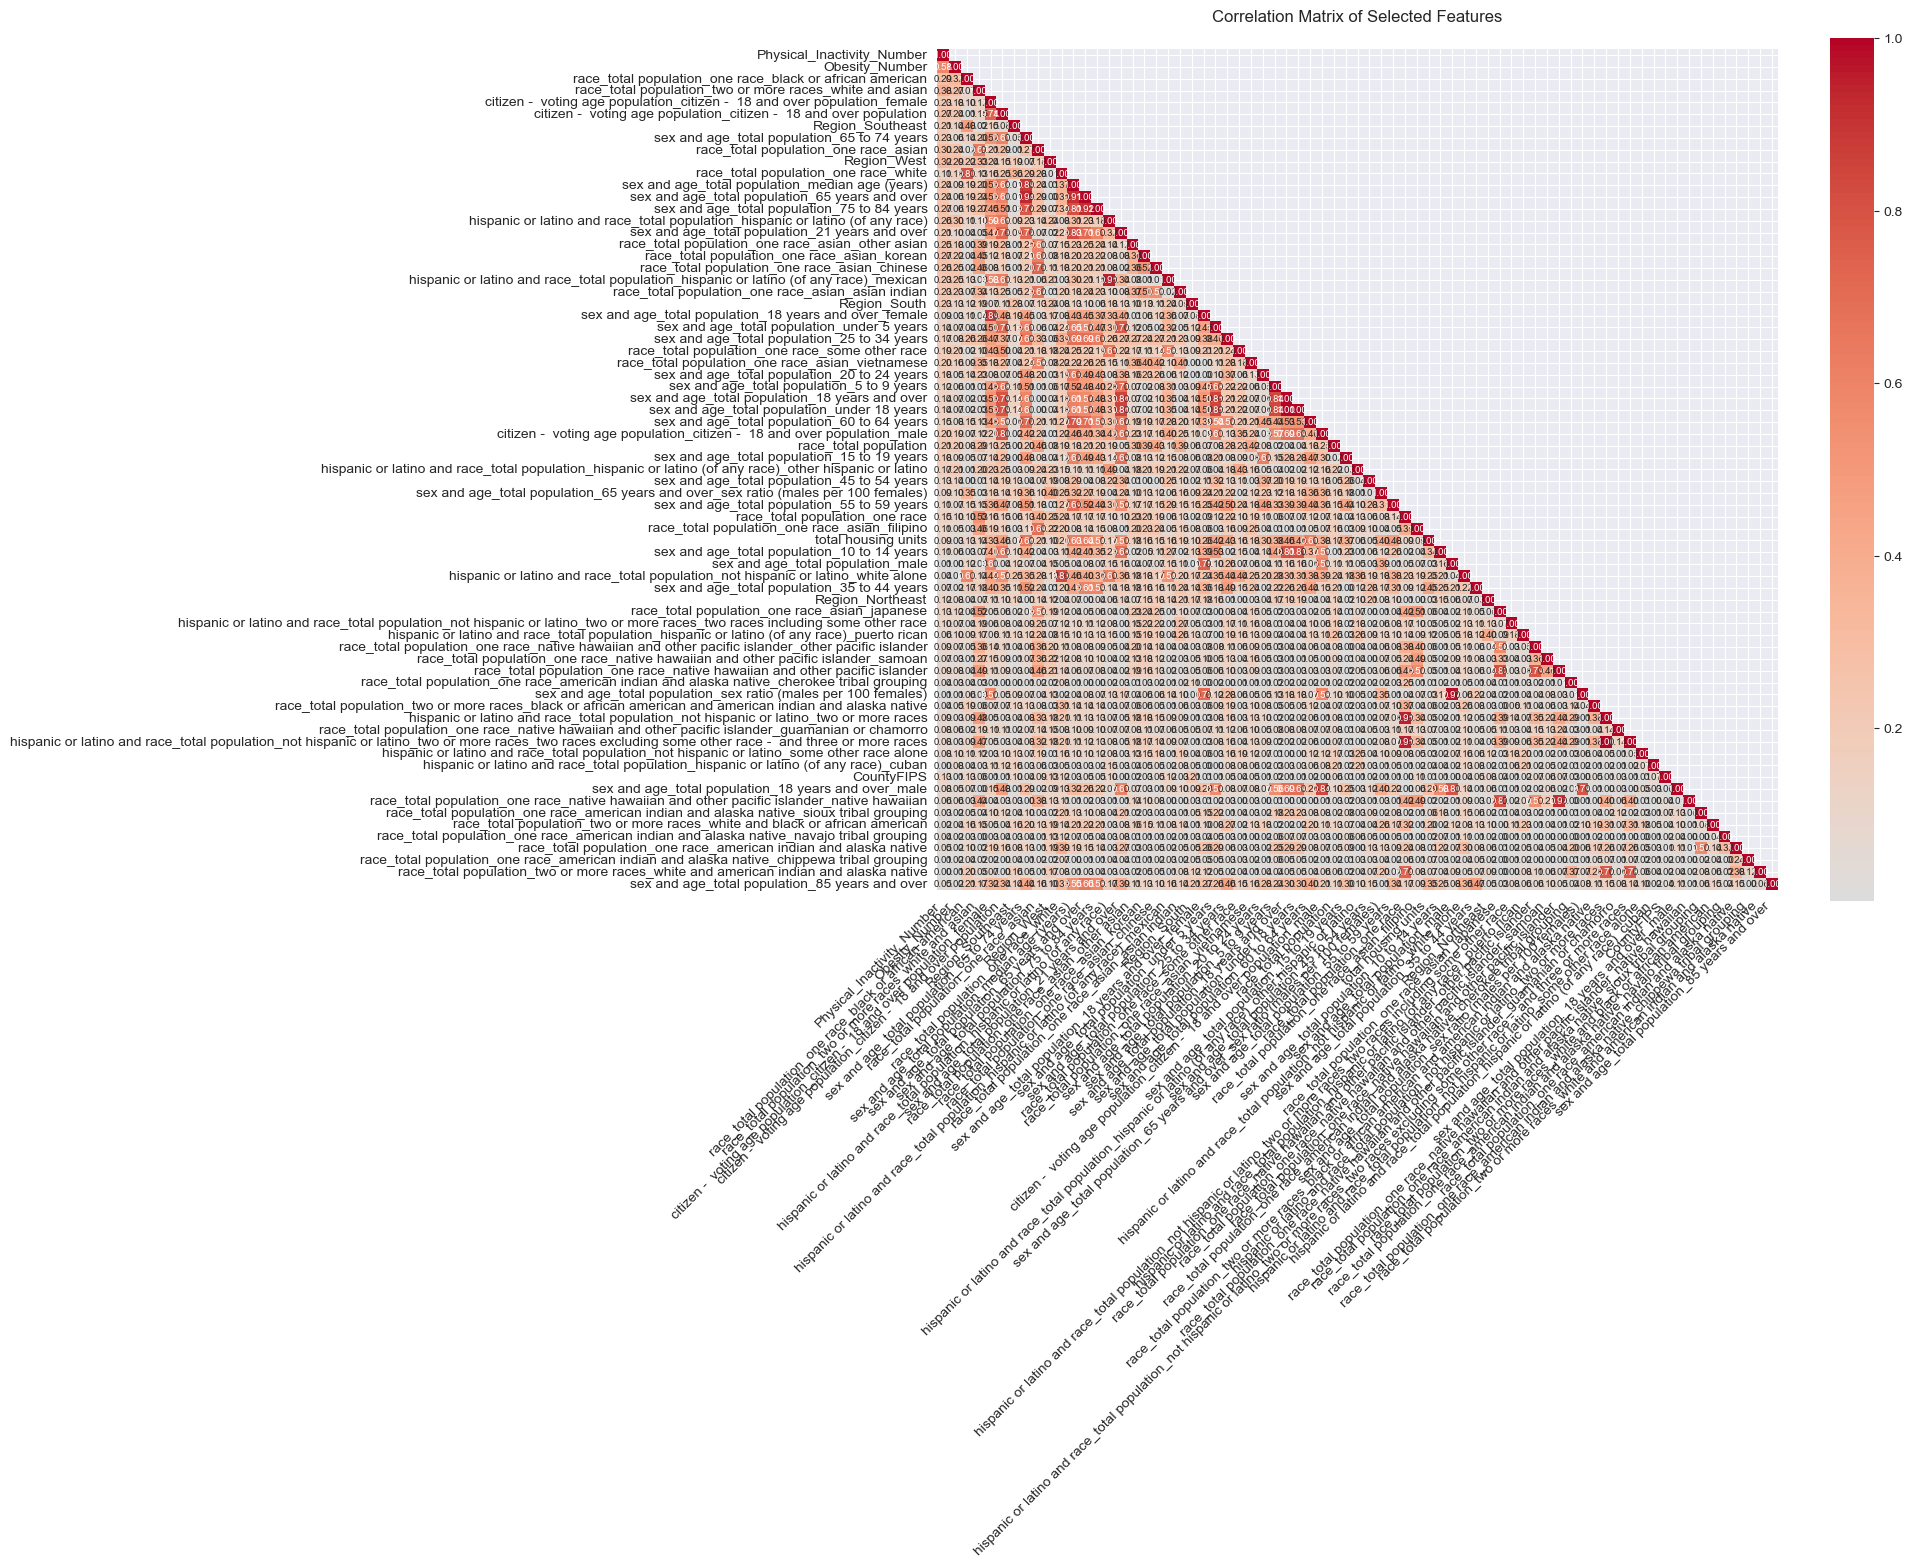


Initial features selected: 71

Highly correlated feature pairs (correlation > 0.7):
--------------------------------------------------------------------------------

sex and age_total population_under 18 years vs sex and age_total population_18 years and over
Correlation: 1.000
F-Scores: 79.15 vs 79.15
Recommendation: Consider removing sex and age_total population_under 18 years

hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some other race -  and three or more races vs hispanic or latino and race_total population_not hispanic or latino_two or more races
Correlation: 0.999
F-Scores: 8.80 vs 10.03
Recommendation: Consider removing hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some other race -  and three or more races

sex and age_total population_sex ratio (males per 100 females) vs sex and age_total population_male
Correlation: 0.970
F-Scores: 11.80 vs 19.58
Recomme

In [26]:
# Using scikit-learn's SelectKBest Method to select the k most important features based on a scoring function. This method can be used to select
# the most essential features and remove the highly correlated ones. 
# -----

# Defining the number of features to keep. Starting with the 71 remaining features from above.
def select_features_with_collinearity(X, y, k=71, correlation_threshold=0.7):
    """
    Select features while checking for collinearity
    
    Parameters:
    X: pd.DataFrame - Feature matrix
    y: pd.Series - Target variable
    k: int - Number of features to select initially
    correlation_threshold: float - Threshold for correlation between features
    
    Returns:
    X_selected: DataFrame with selected features
    feature_scores: DataFrame with feature importance and collinearity info
    """
    # Initial feature selection using F-scores
    selector = SelectKBest(score_func=f_regression, k=k)
    selector.fit(X, y)
    
    # Get initial feature scores
    feature_scores = pd.DataFrame({
        'Feature': X.columns,
        'F_Score': selector.scores_,
        'P_value': selector.pvalues_,
        'Selected': selector.get_support(),
        'Correlation_with_target': [abs(X[col].corr(y)) for col in X.columns]
    })
    
    # Sort by F_Score
    feature_scores = feature_scores.sort_values('F_Score', ascending=False)
    
    # Get selected features
    selected_features = feature_scores.head(k)['Feature'].tolist()
    X_selected = X[selected_features]
    
    # Calculate correlation matrix for selected features
    correlation_matrix = X_selected.corr().abs()
    
    # Find highly correlated pairs
    high_correlation_pairs = []
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if correlation_matrix.iloc[i, j] > correlation_threshold:
                col1 = correlation_matrix.columns[i]
                col2 = correlation_matrix.columns[j]
                f_score1 = feature_scores.loc[feature_scores['Feature'] == col1, 'F_Score'].values[0]
                f_score2 = feature_scores.loc[feature_scores['Feature'] == col2, 'F_Score'].values[0]
                high_correlation_pairs.append({
                    'Feature1': col1,
                    'Feature2': col2,
                    'Correlation': correlation_matrix.iloc[i, j],
                    'F_Score1': f_score1,
                    'F_Score2': f_score2
                })
    
    # Create correlation pairs DataFrame
    correlation_pairs = pd.DataFrame(high_correlation_pairs)
    if not correlation_pairs.empty:
        correlation_pairs = correlation_pairs.sort_values('Correlation', ascending=False)
    
    # Plot correlation matrix
    plt.figure(figsize=(20, 16))  # Larger figure size
    sns.heatmap(correlation_matrix, 
                annot=True, 
                cmap='coolwarm', 
                center=0,
                fmt='.2f',
                square=True,
                annot_kws={'size': 7},  # Smaller annotation font size
                mask=np.triu(np.ones_like(correlation_matrix), k=1))  # Show only lower triangle
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    
    # Adjust title and layout
    plt.title('Correlation Matrix of Selected Features', pad=20)
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\nInitial features selected: {k}")
    if not correlation_pairs.empty:
        print("\nHighly correlated feature pairs (correlation > {}):"
              .format(correlation_threshold))
        print("-" * 80)
        for _, row in correlation_pairs.iterrows():
            print(f"\n{row['Feature1']} vs {row['Feature2']}")
            print(f"Correlation: {row['Correlation']:.3f}")
            print(f"F-Scores: {row['F_Score1']:.2f} vs {row['F_Score2']:.2f}")
            print("Recommendation: Consider removing",
                  row['Feature2'] if row['F_Score1'] > row['F_Score2'] 
                  else row['Feature1'])
    else:
        print("\nNo highly correlated features found.")
    
    # Suggest features to remove
    features_to_remove = set()
    if not correlation_pairs.empty:
        for _, row in correlation_pairs.iterrows():
            # Keep feature with higher F-score
            feature_to_remove = (row['Feature2'] if row['F_Score1'] > row['F_Score2']
                               else row['Feature1'])
            features_to_remove.add(feature_to_remove)
    
    print(f"\nNumber of features suggested for removal due to collinearity: "
          f"{len(features_to_remove)}")
    if features_to_remove:
        print("\nFeatures suggested for removal:")
        print(list(features_to_remove))
    
    # Create final feature set
    final_features = [f for f in selected_features if f not in features_to_remove]
    X_final = X[final_features]
    
    print(f"\nFinal number of features after collinearity check: {len(final_features)}")
    
    return X_final, feature_scores, correlation_pairs

# Select features while checking for collinearity
X_selected, feature_scores, collinear_pairs = select_features_with_collinearity(
    X, y, k=71, correlation_threshold=0.7
)

# View final selected features
print("\nFinal selected features:")
print(X_selected.columns.tolist())

Given the above results, below we will proceed with dropping the 25 features due to collinearity. We are keeping the features with the higher F-score (more predictive power) to simplify our models and hopefully improve model performance.

In [27]:
#
# Get the list of features to remove from collinear_pairs
#--------
features_to_remove = set()
for _, row in collinear_pairs.iterrows():
    # Remove the feature with lower F-score from each pair
    feature_to_remove = (row['Feature2'] if row['F_Score1'] > row['F_Score2'] 
                        else row['Feature1'])
    features_to_remove.add(feature_to_remove)

# Drop these features from the dataset
X_final = X.drop(columns=list(features_to_remove))

# 3. Verify the shape
print(f"Original shape: {X.shape}")
print(f"Final shape: {X_final.shape}")

# 4. View the remaining features
print("\nRemaining features:")
print(X_final.columns.tolist())


Original shape: (3112, 71)
Final shape: (3112, 46)

Remaining features:
['CountyFIPS', 'Obesity_Number', 'Physical_Inactivity_Number', 'sex and age_total population_65 years and over_sex ratio (males per 100 females)', 'race_total population', 'race_total population_one race', 'race_total population_one race_black or african american', 'race_total population_one race_american indian and alaska native', 'race_total population_one race_american indian and alaska native_cherokee tribal grouping', 'race_total population_one race_american indian and alaska native_chippewa tribal grouping', 'race_total population_one race_american indian and alaska native_navajo tribal grouping', 'race_total population_one race_american indian and alaska native_sioux tribal grouping', 'race_total population_one race_asian', 'race_total population_one race_asian_asian indian', 'race_total population_one race_asian_filipino', 'race_total population_one race_asian_japanese', 'race_total population_one race_asia

In [28]:
#
# Training/test split
# We will randomly divide the data set into two smaller sets: one for training and one for testing first. We begin by splitting the data into a 
# training set that contains 80% of the orgiinal dataset and a test set with 20% of the orginal data.
#-----------

# set the random seed
np.random.seed(10)


# split the data so that it returns 4 values: X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X_final,             # specify training dataset, our reduced X
                                                    y,                   # specify test dataset
                                                    train_size=0.8,      # specify proportional split for training
                                                    test_size=0.2)       # specify proportional split for test

In [29]:
#
# Validation split
#-----------

# train_test_split returns 4 values: X_train, X_test, y_train, y_test, so how do we create a 60-20-20 train-validate-test split?
#
# To ensure we are able to adjust our models, we will save the test set until the very end and only use it once and create a validation
# set. We will create a validation set by further splitting our training data so that 75% remains in training and 25% is reserved for valudation. This 
# makes the final split is 60% training,20% validation, and 20% test. See below:

X_train, X_validate, y_train, y_validate =  train_test_split(X_train,
                                                             y_train,
                                                             train_size=0.75,
                                                             test_size=0.25)

In [30]:
# Print shapes to verify
print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_validate.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (1866, 46)
Validation set shape: (623, 46)
Test set shape: (623, 46)


# Standardization
We will standardize the data *after* splitting our data into train, test, validate because we want to avoid information about the test data spilling into the training data. By standardizing after splitting the data, we ensure the standardized data only includes information from each feature (train, validate, test) of the data, avoiding data leakage. 

In [31]:
#
# Standardization 
#
#-----------
# Given that we want to only standardize non-dichotomous variables, we need to find a 
# solution that will loop over only the columns we want to standardize. The code below
# identifies all non-dichotomous variables in our dataset and only standardizes those.

# load library and create instance of Standard Scaler 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


# identify non-dichotomous columns we want to transform
columns = list(X_test.select_dtypes(include=['number']).loc[:, X_test.nunique() > 2])

# use loop to transform training data for only columns we want to transform
for column in columns:
    X_train[column] = scaler.fit_transform(X_train[column].values.reshape(-1, 1)).flatten()

# use loop to transform validation data for only columns we want to transform
for column in columns:
    X_validate[column] = scaler.fit_transform(X_validate[column].values.reshape(-1, 1)).flatten()

# use loop to transform test data for only columns we want to transform
for column in columns:
    X_test[column] = scaler.fit_transform(X_test[column].values.reshape(-1, 1)).flatten()

## 4. Train Models

In this section, train your models. 

**Note that if you use Lasso, you will likely need to specify a very low penalty (e.g., an alpha of 0.001) because of convergence problems.**

### 4.1 Describe models

Detail the basic logic and assumptions underlying each model, its pros/cons, and why it is a plausible choice for this problem.

**MODEL DESCRIPTION(S):** 
1) Linear regression (OLS): To begin, we will start with an OLS model as a helpful baseline. OLS assumes a linear realtionahsip between predictors and diabetes rates, errors are independent, homoscedastic, and normally distributed. It also assumes no multicollinearity among predictors, which we attempted to address above through feature selection. It also assumes that features independently affect the outcome. The pros of using an OLS model are that its coefficients are highly interpretable, it is fast to compute, and provides statistical inference. It is also the easiest to explain to policymakers. However, as it assumes linear relationships, it may not be appropriate for predictors that don't have a linear relationship with diabetes rates. It also does not do well with correlated features. We will use it as a helpful baseline but keep its limitations in mind.
2)  Ridge regression: Ridge regression is similar to OLS but adds L2 regularization. It shrinks coefficients toward zero, and assumes linear relationships. However, it handles correlated features better than OLS. Pros associated with this model are that it reduces overfitting compared to OLS, handles multicollinearity better and maintains some of the interpretability. It also keeps all the features in the model. Cons are that it still assumes a linear relationship, which as with OLS, might not always be appropriate. This is a stronger candidate given likely correlations.
3)  LASSO regression: This model is similar to Ridge but it uses L1 regularization and can shrink coeffients exactly to zero. It assumes features are irrelevant and still assumes linear relationships. Pros of this model are that it reduces overfitting, performs feature selection, maintains interpretability and is good for high-dimentaional data. It also identifies the most important predictors. Cons associated with this model are that it still assumes linear relationships and could potentially elimiate useful features. This model is a very strong candidate for this problem.


### 4.2 Train models

Train each model in the training set, and be sure to tune hyperparameters if appropriate. Report any relevant summary statistics from the training set, including how well each model fits the training data.

#### Model 1:  Linear regression (Ordinary Least Squares) 

In [32]:
#
# Model 1 training
#-----------

# creating the linear model
lin_reg = LinearRegression()

In [33]:
#
# To get a quantitative value for how well our linear model is predicting diabetes rates, we will calcualte the root mean squared error.
# -------------
# Create function to calculate the root mean squared error
#-----------

def rmse(pred, actual):
    return np.sqrt(np.mean((pred - actual) ** 2))

In [34]:
# Linear regression tuning
#-----------
# specify the hyperparameters
param_grid = {'fit_intercept': [True, False]}          

# execute the grid search
lin_grid_reg = GridSearchCV(estimator=lin_reg,      # model to be tuned
                           param_grid=param_grid,    # parameters to be searched
                           cv=3)                     # 3-fold cross-validation

# Fit the grid search
lin_grid_reg.fit(X_train, y_train)                 

# Get the best model
lin_model = lin_grid_reg.best_estimator_

# print the results  
print(lin_grid_reg.cv_results_["params"][np.argmax(lin_grid_reg.cv_results_["mean_test_score"])])
print('Best CV R^2:', max(lin_grid_reg.cv_results_["mean_test_score"]))
print('Training R²:', lin_grid_reg.best_estimator_.score(X_train, y_train))

{'fit_intercept': True}
Best CV R^2: 0.49187299506403254
Training R²: 0.5304920686298347


The above training R2 (0.5305) indicates that our best Linear model predicts 0.5305 of the variance in the target variable (diabetes_number). 

#### Model 2:  Ridge Regression

In [35]:
#
# Model 2 training
#-----------

# Creating and fitting a Ridge regression model
ridge_reg = Ridge()                                                                 


In [36]:
# To identify the best performing Ridge model, we will run 7*2*4 = 56 different configurations, each with 3-fold cross validation

# specify the hyperparameters
param_grid = {'alpha': np.array([0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0]),
              'fit_intercept': [True, False],
              'solver': ['auto', 'svd', 'cholesky', 'lsqr']}

# execute the grid search
ridge_grid_reg = GridSearchCV(estimator=ridge_reg,    # model to be tuned
                             param_grid=param_grid,    # parameters to be searched
                             cv=3)                     # 3-fold cross-validation

# Fit the grid search
ridge_grid_reg.fit(X_train, y_train)                 

# Get the best model
ridge_model = ridge_grid_reg.best_estimator_

# print the results
print(ridge_grid_reg.cv_results_["params"][np.argmax(ridge_grid_reg.cv_results_["mean_test_score"])])
print('Best CV R^2:', max(ridge_grid_reg.cv_results_["mean_test_score"]))
print('Training R²:', ridge_grid_reg.best_estimator_.score(X_train, y_train))



{'alpha': 100.0, 'fit_intercept': True, 'solver': 'auto'}
Best CV R^2: 0.5000689239992666
Training R²: 0.5280613523621435


After executing a grid search to identify the best performing Ridge model, it looks like the Best CV R-squared is 0.5001, which is only a bit higher than the OLS model (0.49187). The above training R2 indicates that our best Ridge model predicts 0.5281 of the variance in the target variable, which is slightly less than our Linear model. Given that it is very similar, this suggests that our features are not highly collinear. This is unsurprising given that we did comprehensive feature selection above.

#### Model 3:  LASSO Regression

In [37]:
#
# Model 3 training
#-----------
# Creating a LASSO regression model
lasso_reg = Lasso(alpha=0.001, max_iter=15000)  


In [38]:
# Lasso regression tuning
#-----------
# specify the hyperparameters
param_grid = {'alpha': np.array([0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]),
              'fit_intercept': [True, False],
              'selection': ['cyclic', 'random']}

# execute the grid search
lasso_grid_reg = GridSearchCV(estimator=lasso_reg,    # model to be tuned
                             param_grid=param_grid,    # parameters to be searched
                             cv=3)                     # 3-fold cross-validation

# Fit the grid search
lasso_grid_reg.fit(X_train, y_train)                 

# Get the best model
lasso_model = lasso_grid_reg.best_estimator_

# print the results
print(lasso_grid_reg.cv_results_["params"][np.argmax(lasso_grid_reg.cv_results_["mean_test_score"])])
print('Best CV R^2:', max(lasso_grid_reg.cv_results_["mean_test_score"]))
print('Training R²:', lasso_grid_reg.best_estimator_.score(X_train, y_train))

{'alpha': 0.0001, 'fit_intercept': True, 'selection': 'cyclic'}
Best CV R^2: 0.49699520870802233
Training R²: 0.5282931827244137


After running a gridsearch for the LASSO model, we find that the best CV R2 is 0.497, which is lower than the best CV R2 for Ridge regression (0.5001). 
The above training R2 indicates that our best LASSO model predicts 0.5283 of the variance in the target variable, which is also slightly less than our
linear model. Similar to the Ridge model, this suggests our selected features are not redundant and actually predictive of diabetes rates.

## 5. Validate and Refine Models

### 5.1 Predict on the validation set
Using each of the models you trained, predict outcomes in the validation set. Evaluate how well each model did.

#### Model 1:  Linear Regression

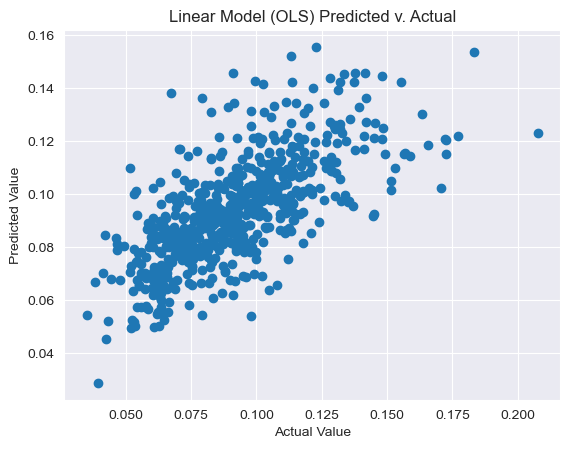

Validation R²: 0.45716388531136465
Validation RMSE: 0.019175101583437514


In [39]:
#
# Evaluate how good the linear model is by assessing the difference between the predicted values and the actual values (e.g., the error).
# We will use the validation dataset and the trained model, and predict the rate of diabetes. 
#-----------
# Predict using the linear model on validation data
lin_pred = lin_model.predict(X_validate)

# Create scatter plot of predicted vs actual values
plt.scatter(y_validate, lin_pred)
plt.title('Linear Model (OLS) Predicted v. Actual')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.show()

# Print validation metrics
print('Validation R²:', lin_model.score(X_validate, y_validate))
print('Validation RMSE:', rmse(lin_pred, y_validate))

Per the above scatter plot, the X-axis (actual value) shows true diabetes rates ranging from about 0.05 to .20. The Y-axis (predicted value) shows the model's predictions ranging similarly. The points roughly follow a diagonal trend, which is good as it means predictions correlate with actual values. However, there's some scatter/spread around this trend, indicating imperfect predictions.

The Validation RMSE of 0.019175 means that on average, the model's predictions deviate from the true values by about 0.019. This aligns with what we see in the scatter plot. Given that diabetes rates in the data range from ~5% to 20%, an error of 1.9 percentage points is relatively significant but not terrible. 

#### Model 2:  Ridge Regression

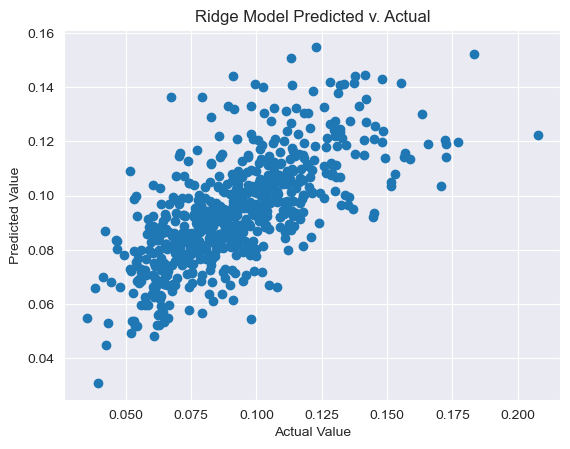

Validation R²: 0.46019100363007714
Validation RMSE: 0.019121561989879722


In [40]:
#
# Evaluate how good the ridge model is by assessing the difference between the predicted values and the actual values (e.g., the error).
# We will use the validation dataset and the trained model, and predict the rate of diabetes. 
#-----------
# Predict using the ridge model on validation data
ridge_pred = ridge_model.predict(X_validate)

# Create scatter plot of predicted vs actual values
plt.scatter(y_validate, ridge_pred)
plt.title('Ridge Model Predicted v. Actual')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.show()

# Print validation metrics
print('Validation R²:', ridge_model.score(X_validate, y_validate))
print('Validation RMSE:', rmse(ridge_pred, y_validate))

The above scatter plot shows a similar positive correlation between predicted and actual values as the linear model and the range of values is the same. This scatter plot shows how the Ridge regression and the OLS are very similar. This could be because multicollinearity isn't a major issue in this dataset as we dropped features that were highly collinear. 

The Ridge Validation R2 (0.46019) is also only slightly higher than the OLS validation R2 which is 0.45716. This suggests that the Ridge model is generalizing slightly better to new data. Finally, the Validation RMSE (0.01912) is also slightly better than the OLS RMSE (0.019175). Given the nearly identical performance, OLS might be preferable to Ridge regression given that it is simpler and more easily interpretable, which is important to policymakers.

#### Model 3:  LASSO Regression

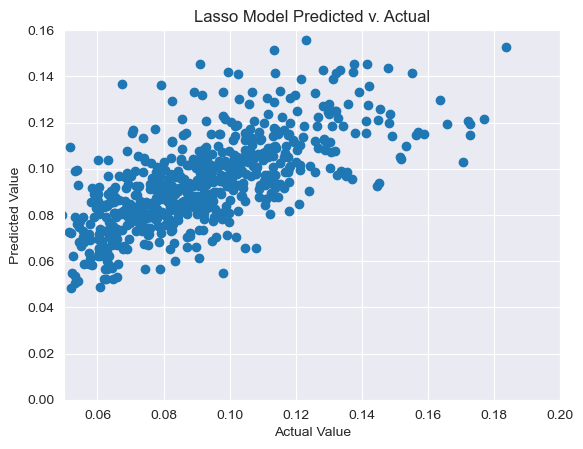

Validation R²: 0.4620911672060093
Validation RMSE: 0.019087877735947757


In [41]:
#
# Evaluate how good the lasso model is by assessing the difference between the predicted values and the actual values (e.g., the error).
# We will use the validation dataset and the trained model, and predict the rate of diabetes. 
#-----------
# Predict using the lasso model on validation data
lasso_pred = lasso_model.predict(X_validate)

# Create scatter plot of predicted vs actual values
plt.scatter(y_validate, lasso_pred)
plt.title('Lasso Model Predicted v. Actual')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
# Set axis limits to facilitate comparison with other models
plt.ylim(0, 0.16)
plt.xlim(0.05, 0.20)
plt.show()

# Print validation metrics
print('Validation R²:', lasso_model.score(X_validate, y_validate))
print('Validation RMSE:', rmse(lasso_pred, y_validate))

The above scatterplot shows how the LASSO model's predictions are similar to the previous two models but it seems to slightly underpredict at higher actual values. There is also more variance in the predictions when actual values are higher. The validation R2 is 0.4621 which is slightly higher than the validation R2 for the Ridge model (0.46019). Fially the validation RMSE is 0.01909 which is slightly lower than the validation RMSE for the Ridge model (0.01912). As such, the LASSO model does not provide a big improvement on OLS or Ridge. This reinforces our previous findings and suggests that multicollinearity is not a problem in our dataset. Because of this, there is not much need for regularization. 

### 5.2 Predict on the test set

Now, choose your best performing model of the three, select out unimportant feature(s), retrain the model, and then predict on the test set. 

#### Best model: Linear regression (OLS) model

While the Ridge and LASSO models showed tiny improvements on the OLS model (RMSE decrease from linear to LASSO model was only a 0.455% improvement) and because of the simplicity and interpretability of the OLS model and the importance of both of these characteristics within the policy context, we will select the OLS model to retrain and predict on the test set.


#### Select out unimportant features
To select out unimportant features, we must review the coefficients (absolute values) from our linear model.

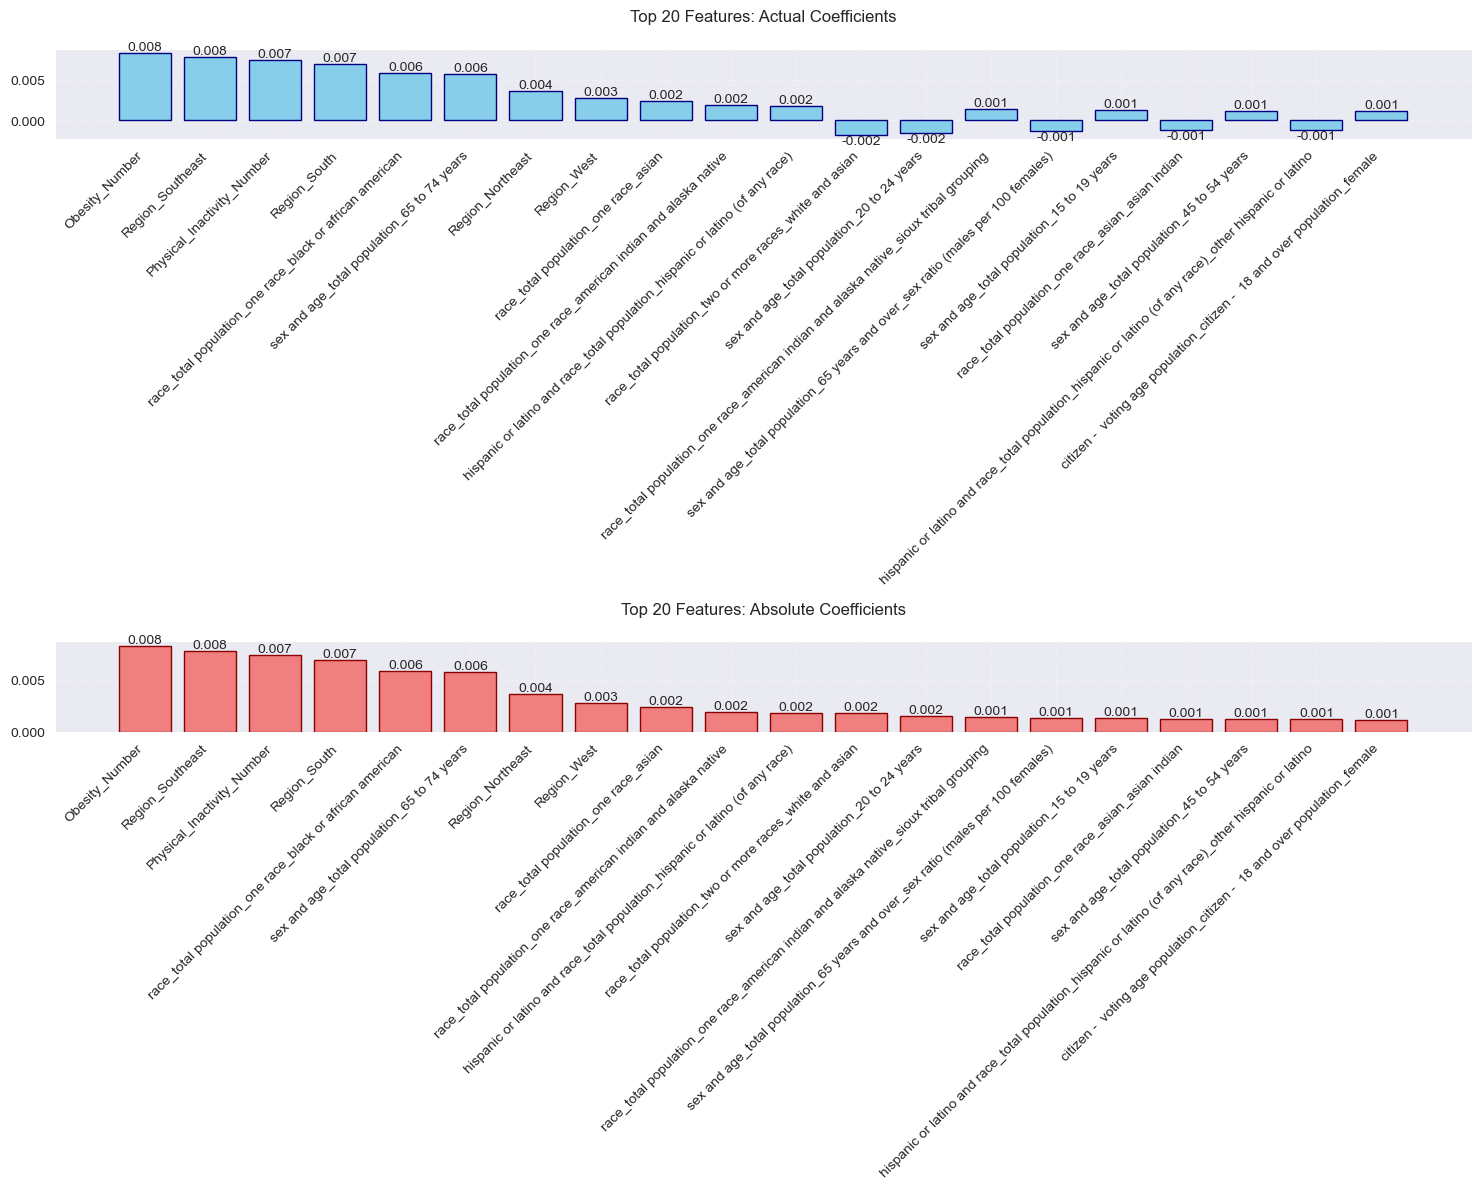


Top 20 Features and their coefficients:
                                              Feature  Actual_Coefficient  \
1                                      Obesity_Number            0.008305   
44                                   Region_Southeast            0.007761   
2                          Physical_Inactivity_Number            0.007441   
43                                       Region_South            0.006931   
6   race_total population_one race_black or africa...            0.005868   
40        sex and age_total population_65 to 74 years            0.005752   
42                                   Region_Northeast            0.003611   
45                                        Region_West            0.002752   
12               race_total population_one race_asian            0.002363   
7   race_total population_one race_american indian...            0.001922   
26  hispanic or latino and race_total population_h...            0.001805   
24  race_total population_two or mo

In [42]:
# Get coefficients from best Linear model
coef = lin_grid_reg.best_estimator_.coef_

# Create DataFrame of features and their coefficients
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Actual_Coefficient': coef,
    'Absolute_Coefficient': abs(coef)
})

# Sort by absolute coefficient value
feature_importance = feature_importance.sort_values('Absolute_Coefficient', ascending=False)

# Create stacked plots with larger figure size and adjusted spacing
plt.figure(figsize=(15, 12))  # Increased figure size

# Adjust subplot parameters
plt.subplots_adjust(hspace=0.5)  # Increased space between plots

# Top plot: Actual coefficients
plt.subplot(2, 1, 1)
bars = plt.bar(range(20), feature_importance['Actual_Coefficient'][:20], color='skyblue', edgecolor='navy')
plt.xticks(range(20), feature_importance['Feature'][:20], rotation=45, ha='right')
plt.title('Top 20 Features: Actual Coefficients', pad=20)
plt.grid(True, alpha=0.3, linestyle='--')
# Add value labels on the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom' if height > 0 else 'top')

# Bottom plot: Absolute coefficients
plt.subplot(2, 1, 2)
bars = plt.bar(range(20), feature_importance['Absolute_Coefficient'][:20], color='lightcoral', edgecolor='darkred')
plt.xticks(range(20), feature_importance['Feature'][:20], rotation=45, ha='right')
plt.title('Top 20 Features: Absolute Coefficients', pad=20)
plt.grid(True, alpha=0.3, linestyle='--')
# Add value labels on the bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.3f}',
             ha='center', va='bottom')

# Adjust layout
plt.tight_layout()
plt.show()

# Print top 20 features and their coefficients
print("\nTop 20 Features and their coefficients:")
print(feature_importance[['Feature', 'Actual_Coefficient', 'Absolute_Coefficient']].head(20))


In [43]:
# Based on the coefficients in the output above, it looks like there are several features with coefficients less than 0.002, which means these features
# have minimal impact on my model. As such, to simplify the model, we will set a threshold at 0.002 and drop all features below this threshold.

# Set threshold
threshold = 0.002

# Get features to keep
features_to_keep = feature_importance[feature_importance['Absolute_Coefficient'] > threshold]['Feature'].tolist()

# Create new X dataset with only important features
X_important = X_train[features_to_keep]

print(f"Number of features dropped: {len(X_train.columns) - len(features_to_keep)}")
print(f"Number of features kept: {len(features_to_keep)}")
print("\nFeatures kept:")
print(features_to_keep)

Number of features dropped: 37
Number of features kept: 9

Features kept:
['Obesity_Number', 'Region_Southeast', 'Physical_Inactivity_Number', 'Region_South', 'race_total population_one race_black or african american', 'sex and age_total population_65 to 74 years', 'Region_Northeast', 'Region_West', 'race_total population_one race_asian']


#### Retrain OLS model with only selected important features

In [44]:
# 
# Create new training and validation sets with only important features
#
X_train_important = X_train[features_to_keep]
X_validate_important = X_validate[features_to_keep]

# Create and train new linear model with same parameters as before
lin_reg_final = LinearRegression()
param_grid = {'fit_intercept': [True, False]}

# Perform grid search
lin_grid_reg_final = GridSearchCV(estimator=lin_reg,
                                param_grid=param_grid,
                                cv=3)

# Fit the model
lin_grid_reg_final.fit(X_train_important, y_train)

# Make predictions on validation set
best_lin_pred_final = lin_grid_reg_final.predict(X_validate_important)

# Print results
print("Model Performance with Selected Features:")
print(f"Best parameters: {lin_grid_reg_final.best_params_}")
print(f"Best CV R^2: {lin_grid_reg_final.best_score_:.4f}")
print(f"Validation R^2: {lin_grid_reg_final.score(X_validate_important, y_validate):.4f}")
print(f"Validation RMSE: {np.sqrt(mean_squared_error(y_validate, best_lin_pred_final)):.4f}")

Model Performance with Selected Features:
Best parameters: {'fit_intercept': True}
Best CV R^2: 0.4909
Validation R^2: 0.4537
Validation RMSE: 0.0192


Note that after removing 37 unimportant features, the OLS model performed as well as it performed before feature removal. Removing 37 features did not hurt model performance and the 9 remaining are sufficient to perform as well as the original model.

#### Predict on the test set

Final Model Performance on Test Set:
Test R^2: 0.4481
Test RMSE: 0.0205

First few predictions vs actual values:
        Actual  Predicted  Difference
2138  0.105753   0.109509   -0.003756
488   0.115550   0.125612   -0.010062
1777  0.100332   0.093358    0.006974
1321  0.083495   0.087034   -0.003539
1260  0.078224   0.085451   -0.007227


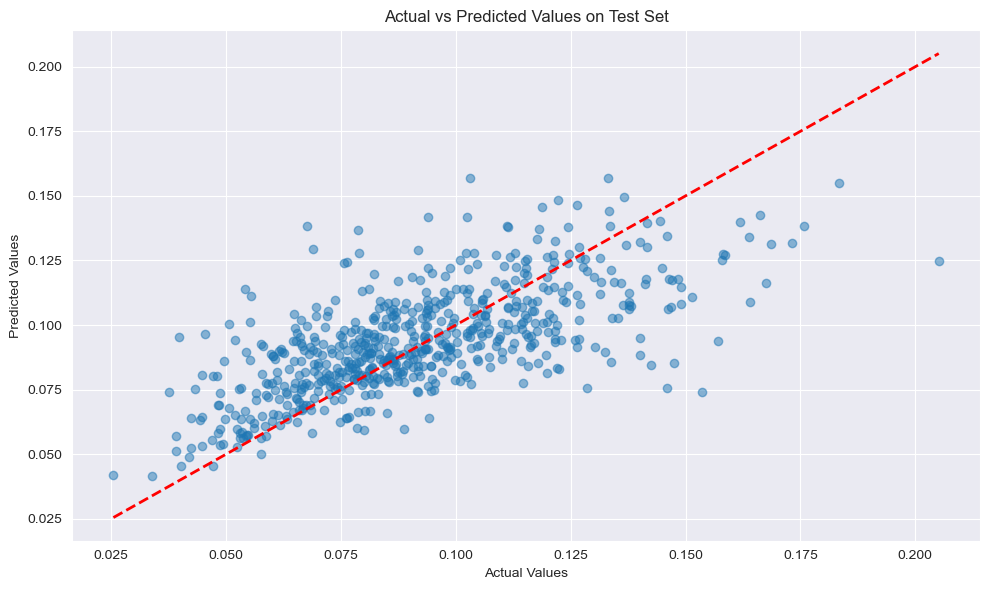

In [45]:
# Make predictions on test set with final model
test_predictions = lin_grid_reg_final.predict(X_test[features_to_keep])

# Calculate performance metrics on test set
test_r2 = lin_grid_reg_final.score(X_test[features_to_keep], y_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

# Print test set results
print("Final Model Performance on Test Set:")
print(f"Test R^2: {test_r2:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

# Create a DataFrame with actual vs predicted values
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': test_predictions,
    'Difference': y_test - test_predictions
})

print("\nFirst few predictions vs actual values:")
print(results_df.head())


# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values on Test Set')
plt.tight_layout()
plt.show()



The above results demonstrate that our final simplified linear model had a test RMSE of 0.0205 and a Test R2 of 0.4481. Our simplified model performed as well as the two more complicated models, Ridge and LASSO, and retained the advantage of interpretability of linear models. 

#### Advantage of using both validation and test sets.

The advantage of using both validation and test sets in the social sciences and public policy is that the validation set helps us tune model parameters and detect overfitting during model development. The test set then provides an unbiased esimtae of real world performance. In the social sciences and policy world, this helps validate that findings are generalizable beyond our sample data and reduces the likelihood that we implement policies based on spuriouscorrelations. This is particularly important given that policy decisions affect people's everyday lives. Using the above method also addresses concerns about reproducibility in the social sciences. 

### 5.3 Impement a cross-validation approach

Finally, implement a cross-validation approach for your best model and evaluate the results.

In [46]:
#
# Run cross-validation
#
# Get best parameters from GridSearchCV
best_params = lin_grid_reg_final.best_params_

# Analyze different k values using best model
k_values = [3, 5, 10]
cv_results = []

for k in k_values:
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    
    # Use best model configuration
    model = LinearRegression(**best_params)
    
    # Get CV scores
    cv_scores = cross_val_score(model, X_train_important, y_train, cv=kf, scoring='r2')
    
    print(f"\nResults for k={k}:")
    print(f"R² scores: {cv_scores}")
    print(f"Mean R²: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")



Results for k=3:
R² scores: [0.5371602  0.48728013 0.4605833 ]
Mean R²: 0.4950 (+/- 0.0635)

Results for k=5:
R² scores: [0.54711941 0.50363432 0.50126306 0.48047118 0.44012288]
Mean R²: 0.4945 (+/- 0.0696)

Results for k=10:
R² scores: [0.60779658 0.48855791 0.52530917 0.48440711 0.5129654  0.49612416
 0.46124186 0.50255005 0.38156114 0.50089125]
Mean R²: 0.4961 (+/- 0.1062)


The above results show that while different k values (3, 5, and 10) produced similar mean R² scores around 0.495-0.496, they showed varying levels of variance. k=3 emerged as potentially the most practical choice, offering the lowest variance (±0.0635) while maintaining similar performance to higher k values and being computationally efficient. Compared to the train/validation/test split (which showed a R² for the final linear model of 0.4481 and a test RMSE of 0.0205), the cross-validation approach found a slighltly higher R2 (0.495), but it still provides a reliable estimate of the model's generalization performance, with the actual test set performance being slightly lower but still within expected ranges as shown by the confidence intervals.

## 6. Discussion Questions

In this section, insert responses for discussion questions here.

1. What is bias-variance tradeoff? Why is it relevant to machine learning problems like this one?

The bias of a model typically decreases as you add more features because the error due to having an overly simplistic model (underfitting) is reduced. The variance of a model typically increases as you add more features because the model is more sensitive to fluctuations in the training data that may not be reflected in the testing data (overfitting a model). The bias-variance tradeoff occurs because as model complexity increases, bias tends to decrease and variance tends to increase. In machine learning, both overfitting and underfitting can be concerns, but overfitting seems to be the more challenging problem because it would result in poor generalization to new data or other real world applications. This would also seem more common as researchers aiming to maximize training performance might inadvertently overfit their model. This tradeoff is relevant to machine learning problems like the one we explored in this project because we need to balance between models that are too simple (high bias) and miss important patterns, versus models that are too complex (high variance) and overfit to noise in the training data. In this public health context, underfitting could mean missing counties that need intervention, while overfitting could lead to misallocating limited resources based on spurious correlations. The optimal solution likely involves careful cross-validation, starting with simpler models and gradually increasing complexity while incorporating domain knowledge about diabetes risk factors.

2. Define overfitting, and why it matters for machine learning. How can we address it?

As described above, overfitting occurs when a machine learning model learns to fit the noise or random fluctuations in the training data too closely, rather than learning the true underlying patterns - like memorizing specific test questions instead of understanding core concepts. This matters because an overfit model will perform well on training data but fail to generalize to new, unseen data, making it unreliable for real-world applications and wasting computational resources. Overfitting is particularly dangerous because it can give a false sense of confidence due to excellent training performance, while actually making poor predictions on new data. To address overfitting, we can use techniques like cross-validation to detect it early, collect more training data, or simplify the model through regularization and feature selection. 

3. Discuss your analysis in 2-3 paragraphs. Discuss your findings and recommendations. Which counties or regions would you prioritize for the pilot program? Would your answers change based on whether you want to take into account certain features such as race, gender, or age composition in the county? How confident would you be deploying this sort of model in a real-world application – why or why not?

The below analysis reveals significant geographic and demographic patterns in diabetes risk. The top five highest-risk counties are predominantly located in the Southeast (Alabama, North Carolina, Virginia) with one exception in New Mexico. These counties show predicted diabetes rates ranging from 15.7% to 16.3%, which are significantly above average (as indicated by risk scores over 3 standard deviations above the mean). All five priority counties show relatively high obesity rates (35-39%) and physical inactivity rates (24-38%), suggesting these are key contributing factors to their elevated diabetes risk.

Demographic factors strongly influence diabetes risk patterns. The analysis shows a strong positive correlation (0.556) between diabetes risk and Black/African American population proportion, with counties in the highest quartile (Q4) of Black population showing notably higher risk scores (+0.769). Age composition also matters, with a moderate positive correlation (0.357) between diabetes risk and the 65-74 age group. Interestingly, there's a negative correlation (-0.341) between Asian population proportion and diabetes risk, with counties in the highest quartile of Asian population showing lower risk scores (-0.557).

Based on these findings, I recommend prioritizing diabetes prevention programs in Southeast counties with high obesity and physical inactivity rates, particularly those with larger elderly and African American populations. Specifically, Bullock County and Macon County in Alabama, Hertford County in North Carolina, and Brunswick County in Virginia should be primary targets. Prevention programs should be culturally tailored to address the specific needs of these communities, with particular attention to age-appropriate interventions for the 65-74 age group. The strong demographic correlations suggest that an equity-focused approach, addressing social determinants of health and cultural factors, would be crucial for program success. Additionally, studying the protective factors present in communities with higher Asian populations might provide insights for prevention strategies. 
Given that this intervention is a public health, preventive intervention, I would feel confident deploying it in a real world application as long as it is done with the above considerations in mind. The downside of using this model and implementing the program in a place that is potentially less at risk than the model predicts would primarily be inefficient use of resources. However, given how common diabetes is, even if this program were deployed in a county with smaller rates of diabetes, it could still be beneficial for some in the county. 

In [47]:
def predict_diabetes_risk(model, X_important):
    # Create copy of data to avoid modifications
    analysis_df = X_important.copy()
    
    # Generate predictions
    predictions = model.predict(X_important)
    
    # Add predictions to dataframe
    analysis_df['predicted_diabetes_rate'] = predictions
    
    # Calculate risk score (z-score of predictions)
    analysis_df['risk_score'] = (predictions - predictions.mean()) / predictions.std()
    
    return analysis_df

def identify_priority_regions(analysis_df, risk_threshold=1.0):
    high_risk = analysis_df[analysis_df['risk_score'] >= risk_threshold].copy()
    
    # Sort by risk score
    high_risk = high_risk.sort_values('risk_score', ascending=False)
    
    return high_risk

def analyze_demographic_risk(analysis_df, demographic_columns):
    demographic_analysis = {}
    
    for column in demographic_columns:
        # Calculate correlation with predicted diabetes rate
        correlation = analysis_df[column].corr(analysis_df['predicted_diabetes_rate'])
        
        # Calculate average risk score by quartile of demographic factor
        analysis_df['demographic_quartile'] = pd.qcut(analysis_df[column], q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
        risk_by_quartile = analysis_df.groupby('demographic_quartile')['risk_score'].mean()
        
        demographic_analysis[column] = {
            'correlation': correlation,
            'risk_by_quartile': risk_by_quartile
        }
        
        # Remove temporary quartile column
        analysis_df.drop('demographic_quartile', axis=1, inplace=True)
    
    return demographic_analysis

def visualize_regional_risk(analysis_df):
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Create a 'Region' column combining all region dummy variables
    region_cols = [col for col in analysis_df.columns if col.startswith('Region_')]
    analysis_df['Region'] = 'Other'
    for col in region_cols:
        analysis_df.loc[analysis_df[col] == 1, 'Region'] = col.replace('Region_', '')
    
    # Boxplot of risk scores by region
    sns.boxplot(x='Region', y='risk_score', data=analysis_df, ax=ax1)
    ax1.set_title('Distribution of Diabetes Risk Scores by Region')
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)
    
    # Bar plot of average predicted diabetes rate by region
    region_means = analysis_df.groupby('Region')['predicted_diabetes_rate'].mean()
    region_means.plot(kind='bar', ax=ax2)
    ax2.set_title('Average Predicted Diabetes Rate by Region')
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
    
    plt.tight_layout()
    plt.show()

def run_analysis(model, X_important):
    # Predict diabetes risk
    analysis_df = predict_diabetes_risk(model, X_important)
    
    # Identify priority regions
    priority_regions = identify_priority_regions(analysis_df)
    print("\nTop Priority Regions:")
    print(priority_regions[['predicted_diabetes_rate', 'risk_score']].head())
    
    # Analyze demographic factors - use only the demographic columns that exist in X_important
    demographic_columns = [
        col for col in X_important.columns 
        if any(term in col.lower() for term in ['race', 'sex', 'age'])
    ]
    
    if demographic_columns:
        demographic_analysis = analyze_demographic_risk(analysis_df, demographic_columns)
        print("\nDemographic Risk Analysis:")
        for column, analysis in demographic_analysis.items():
            print(f"\n{column}:")
            print(f"Correlation with diabetes rate: {analysis['correlation']:.3f}")
            print("Risk score by quartile:")
            print(analysis['risk_by_quartile'])
    
    # Visualize regional risk
    visualize_regional_risk(analysis_df)
    
    return analysis_df, priority_regions, demographic_analysis


Top Priority Regions:
      predicted_diabetes_rate  risk_score
5                    0.162886    3.380738
1806                 0.161987    3.336815
43                   0.161099    3.293452
1935                 0.159563    3.218456
2912                 0.157268    3.106365

Demographic Risk Analysis:

race_total population_one race_black or african american:
Correlation with diabetes rate: 0.556
Risk score by quartile:
demographic_quartile
Q1   -0.280326
Q2   -0.374543
Q3   -0.115630
Q4    0.769450
Name: risk_score, dtype: float64

sex and age_total population_65 to 74 years:
Correlation with diabetes rate: 0.357
Risk score by quartile:
demographic_quartile
Q1   -0.630375
Q2    0.006264
Q3    0.266754
Q4    0.357942
Name: risk_score, dtype: float64

race_total population_one race_asian:
Correlation with diabetes rate: -0.341
Risk score by quartile:
demographic_quartile
Q1    0.300949
Q2    0.229742
Q3    0.026698
Q4   -0.556840
Name: risk_score, dtype: float64


C:\Users\Cindy\AppData\Local\Temp\ipykernel_25916\3143212158.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_by_quartile = analysis_df.groupby('demographic_quartile')['risk_score'].mean()
C:\Users\Cindy\AppData\Local\Temp\ipykernel_25916\3143212158.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  risk_by_quartile = analysis_df.groupby('demographic_quartile')['risk_score'].mean()
C:\Users\Cindy\AppData\Local\Temp\ipykernel_25916\3143212158.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain curr

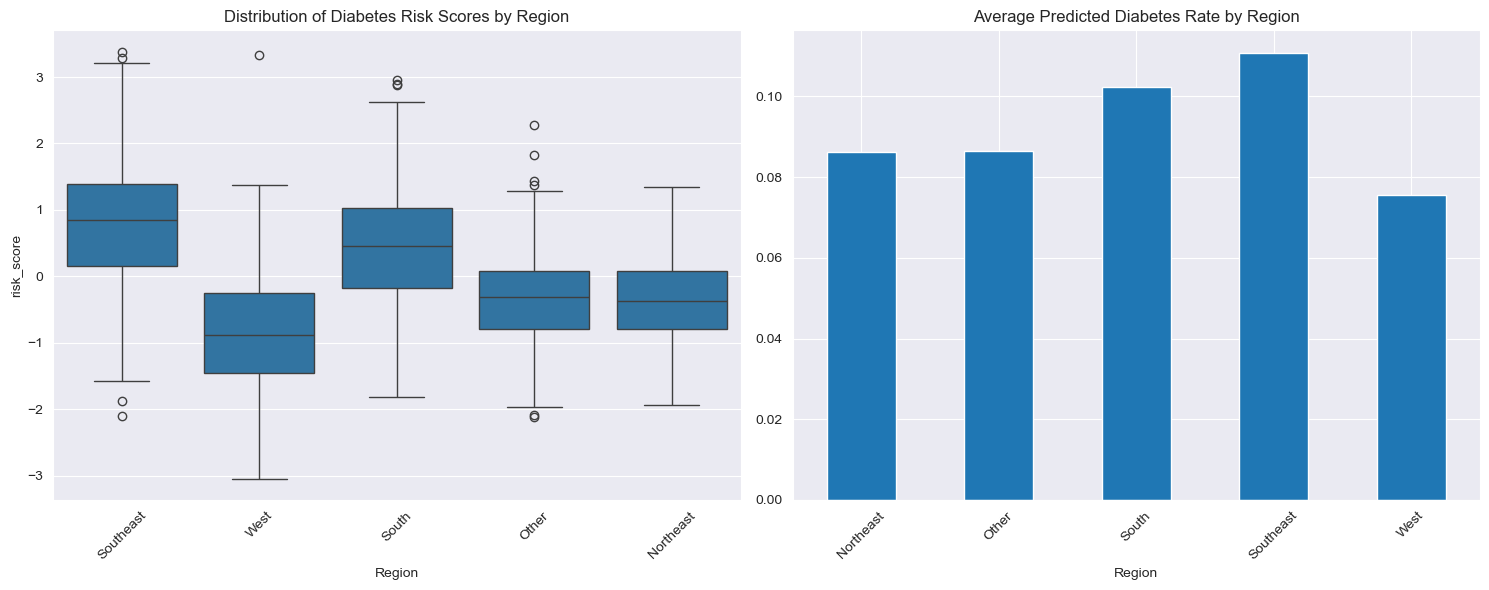


Top Priority Counties:

County: Bullock County, State: Alabama
Predicted Diabetes Rate: 16.3%
Risk Score: 3.38
Obesity Number: 0.35374806800618236
Physical Inactivity Number: 0.3219667697063369

County: Harding County, State: New Mexico
Predicted Diabetes Rate: 16.2%
Risk Score: 3.34
Obesity Number: 0.3572984749455338
Physical Inactivity Number: 0.3790849673202614

County: Macon County, State: Alabama
Predicted Diabetes Rate: 16.1%
Risk Score: 3.29
Obesity Number: 0.3866904586963367
Physical Inactivity Number: 0.24687729610580456

County: Hertford County, State: North Carolina
Predicted Diabetes Rate: 16.0%
Risk Score: 3.22
Obesity Number: 0.36637270732414196
Physical Inactivity Number: 0.3143708856042728

County: Brunswick County, State: Virginia
Predicted Diabetes Rate: 15.7%
Risk Score: 3.11
Obesity Number: 0.35913591359135916
Physical Inactivity Number: 0.31035103510351036


In [48]:
# Use X_important (final 9 features) to predict 
results = run_analysis(lin_grid_reg_final, X_important)
analysis_df, priority_regions, demographic_analysis = results

# Add county information to help interpret results
print("\nTop Priority Counties:")
for idx in priority_regions.index[:5]:  # Look at top 5 highest risk
    print(f"\nCounty: {diabetes.loc[idx, 'County']}, State: {diabetes.loc[idx, 'State']}")
    print(f"Predicted Diabetes Rate: {priority_regions.loc[idx, 'predicted_diabetes_rate']:.1%}")
    print(f"Risk Score: {priority_regions.loc[idx, 'risk_score']:.2f}")
    print(f"Obesity Number: {diabetes.loc[idx, 'Obesity_Number']}")
    print(f"Physical Inactivity Number: {diabetes.loc[idx, 'Physical_Inactivity_Number']}")